In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from ggplot import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')

# Current best result. No other feature

[0]	train-rmse:7.7958e+06	test-rmse:7.80037e+06
[50]	train-rmse:2.39694e+06	test-rmse:2.76631e+06
[100]	train-rmse:2.07912e+06	test-rmse:2.59791e+06
[150]	train-rmse:1.97156e+06	test-rmse:2.56523e+06
[200]	train-rmse:1.89038e+06	test-rmse:2.54726e+06
[250]	train-rmse:1.82037e+06	test-rmse:2.53597e+06
[300]	train-rmse:1.76422e+06	test-rmse:2.53101e+06
[350]	train-rmse:1.7127e+06	test-rmse:2.52498e+06
Performance does not improve from 372 rounds


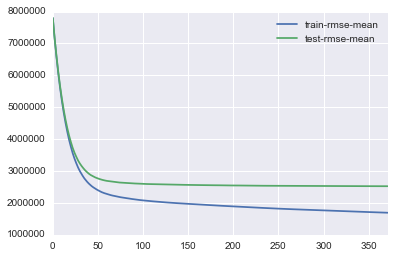

In [33]:
# params = {
#     'eta': 0.05, ## Try 0.01,3,5
#     'max_depth': 5,## Try 4,5,6
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1
# }
# xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
#     verbose_eval=50, show_stdv=False,seed=42)
# xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
# print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

# Add hand made feature, and tsne

In [17]:
def get_ratio_preschool(df):
    df['ratio_preschool'] = df['children_preschool'] / (df['children_school'] + 1)
    return df

train = get_ratio_preschool(train)
test = get_ratio_preschool(test)

In [18]:
def get_extra_area(df):
    df['extra_area'] = df['full_sq'] - df['life_sq']
    return df

train = get_extra_area(train)
test = get_extra_area(test)

In [19]:
def get_floor_ratio(df):
    df['floor_ratio'] = df['max_floor'] - df['floor']
    return df

train = get_floor_ratio(train)
test = get_floor_ratio(test)

In [20]:
def get_room_avg_size(df):
    df['room_avg_size'] = (df['life_sq'] - df['kitch_sq']) / (df['num_room'] + 1)
    return df

train = get_room_avg_size(train)
test = get_room_avg_size(test)

In [21]:
tsne_results = np.load('tsne_all.npy')
train['tsne_1'] = tsne_results[:train.shape[0],0]
train['tsne_2'] = tsne_results[:train.shape[0],1]
test['tsne_1'] = tsne_results[train.shape[0]:,0]
test['tsne_2'] = tsne_results[train.shape[0]:,1]

In [22]:
df_kremlin = pd.read_csv('subarea_from_kremlin.csv')
df_kremlin = df_kremlin[['sub_area', 'distance_from_kremlin']]

In [23]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
train_raw = pd.merge(train_raw, df_kremlin,how='left', on='sub_area')
test_raw = pd.merge(test_raw, df_kremlin,how='left', on='sub_area')
train['distance_from_kremlin'] = train_raw['distance_from_kremlin']
test['distance_from_kremlin'] = test_raw['distance_from_kremlin']

## Add macro features

In [24]:
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

df_macro = pd.read_csv("macro_c.csv",  usecols=['timestamp'] + macro_cols)

train = pd.merge_ordered(train, df_macro, on='timestamp', how='left')
test = pd.merge_ordered(test, df_macro, on='timestamp', how='left')

# data cleaning accoring to https://www.kaggle.com/gunjaagarwal/final-xgboost-try/code

In [30]:
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN

# equal_index = [601,1896,2791]
# test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]

bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN

In [29]:
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN

bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN

In [31]:
# kitch_is_build_year = [13117]
# train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]

In [32]:
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN

In [33]:
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN

In [34]:
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN

In [35]:
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN

In [36]:
train.product_type.value_counts(normalize= True)

0    0.638246
1    0.361754
Name: product_type, dtype: float64

In [37]:
test.product_type.value_counts(normalize= True)

 0    0.652310
 1    0.343383
-1    0.004307
Name: product_type, dtype: float64

In [38]:
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN

In [39]:
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN

In [40]:
# bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
# train.ix[bad_index, "num_room"] = np.NaN
# bad_index = [3174, 7313]
# test.ix[bad_index, "num_room"] = np.NaN

In [41]:
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN

In [42]:
train.floor.describe(percentiles= [0.9999])

count     30295.000000
mean          7.673081
std           5.319135
min           1.000000
50%           7.000000
99.99%       40.911800
max          77.000000
Name: floor, dtype: float64

In [43]:
# bad_index = [23584]
# train.ix[bad_index, "floor"] = np.NaN

In [44]:
train.material.value_counts()
test.material.value_counts()
train.state.value_counts()
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
test.state.value_counts()

2.0    2662
1.0    2266
3.0    1913
4.0     127
Name: state, dtype: int64

In [45]:
# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

In [48]:
# Add month-year
train['timestamp'] = pd.to_datetime(train['timestamp'])
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

test['timestamp'] = pd.to_datetime(test['timestamp'])
month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

In [49]:
# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

In [50]:
# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

In [52]:
# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train.apartment_name=train.sub_area.astype(str) + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area.astype(str) + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

# Add interaction feature of top 10 features

In [91]:
N = 30
topN_features = get_feature_importance(model).Feature.tolist()[:N] + ['build_year']
topN_features

['full_sq',
 'life_sq',
 'extra_area',
 'floor',
 'build_year',
 'max_floor',
 'rel_kitch_sq',
 'micex_cbi_tr',
 'eurrub',
 'kitch_sq',
 'micex_rgbi_tr',
 'tsne_1',
 'kindergarten_km',
 'state',
 'room_avg_size',
 'floor_ratio',
 'hospice_morgue_km',
 'railroad_km',
 'num_room',
 'room_size',
 'balance_trade',
 'mosque_km',
 'school_km',
 'public_healthcare_km',
 'radiation_km',
 'tsne_2',
 'green_zone_km',
 'workplaces_km',
 'cemetery_km',
 'theater_km',
 'build_year']

In [92]:
from sklearn import preprocessing
for f in topN_features:
    train['norm_'+f] = (train[f] - train[f].min())/(train[f].max() - train[f].min())
    test['norm_'+f] = (test[f] - test[f].min())/(test[f].max() - test[f].min())

In [95]:
import itertools
for f_1, f_2 in itertools.combinations(topN_features, 2):
    train['x_'+f_1+'_'+f_2] = train['norm_'+f_1] * train['norm_'+f_2]
    test['x_'+f_1+'_'+f_2] = test['norm_'+f_1] * test['norm_'+f_2]

In [96]:
norm_feature_name_list = ['norm_'+f for f in topN_features]
train = train.drop(norm_feature_name_list, axis=1)
test = test.drop(norm_feature_name_list, axis=1)

## only keep `x_` feature in top 100

In [113]:
x_topN = 200
total_topN_features = get_feature_importance(model).Feature.tolist()[:x_topN]
top_x_features = [f for f in total_topN_features if f[:2] == 'x_']
print len(top_x_features)
print top_x_features

drop_x_feature_list = ['x_'+f_1+'_'+f_2 for f_1, f_2 in itertools.combinations(topN_features, 2) if 'x_'+f_1+'_'+f_2 not in top_x_features]
print len(drop_x_feature_list)

print len(list(itertools.combinations(topN_features, 2)))

train = train.drop(drop_x_feature_list, axis=1)
test = test.drop(drop_x_feature_list, axis=1)

109
['x_full_sq_extra_area', 'x_full_sq_micex_cbi_tr', 'x_full_sq_tsne_2', 'x_full_sq_tsne_1', 'x_full_sq_micex_rgbi_tr', 'x_full_sq_floor', 'x_extra_area_build_year', 'x_full_sq_eurrub', 'x_full_sq_state', 'x_full_sq_num_room', 'x_full_sq_life_sq', 'x_full_sq_floor_ratio', 'x_floor_railroad_km', 'x_micex_rgbi_tr_public_healthcare_km', 'x_build_year_room_avg_size', 'x_full_sq_cemetery_km', 'x_full_sq_school_km', 'x_public_healthcare_km_workplaces_km', 'x_full_sq_kindergarten_km', 'x_school_km_cemetery_km', 'x_full_sq_kitch_sq', 'x_life_sq_floor', 'x_life_sq_school_km', 'x_full_sq_balance_trade', 'x_full_sq_max_floor', 'x_kitch_sq_cemetery_km', 'x_mosque_km_workplaces_km', 'x_full_sq_room_avg_size', 'x_max_floor_floor_ratio', 'x_green_zone_km_theater_km', 'x_micex_cbi_tr_micex_rgbi_tr', 'x_life_sq_micex_rgbi_tr', 'x_build_year_state', 'x_rel_kitch_sq_mosque_km', 'x_life_sq_kitch_sq', 'x_floor_eurrub', 'x_life_sq_micex_cbi_tr', 'x_full_sq_workplaces_km', 'x_kitch_sq_state', 'x_mosque_km_

# Run CV

In [114]:
col = list(test.columns)[2:]

label = train['price_doc']* .968 + 10

In [115]:
dtrain = xgb.DMatrix(train[col],label)
dtest = xgb.DMatrix(test[col])

[0]	train-rmse:7.91895e+06	test-rmse:7.92752e+06
[50]	train-rmse:2.29957e+06	test-rmse:2.6613e+06
[100]	train-rmse:1.98879e+06	test-rmse:2.48025e+06
[150]	train-rmse:1.86569e+06	test-rmse:2.43401e+06
[200]	train-rmse:1.77747e+06	test-rmse:2.41413e+06
[250]	train-rmse:1.70559e+06	test-rmse:2.40194e+06
[300]	train-rmse:1.63589e+06	test-rmse:2.39527e+06
[350]	train-rmse:1.5725e+06	test-rmse:2.39137e+06
[400]	train-rmse:1.5176e+06	test-rmse:2.38818e+06
[450]	train-rmse:1.46681e+06	test-rmse:2.38694e+06
[500]	train-rmse:1.41699e+06	test-rmse:2.38651e+06
[550]	train-rmse:1.37175e+06	test-rmse:2.38696e+06
Performance does not improve from 512 rounds


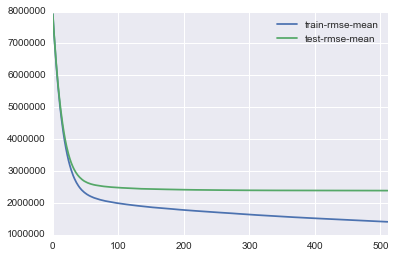

In [122]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')


# Make prediction

In [ ]:
#model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))
model = xgb.train(params,dtrain,num_boost_round=250)

In [ ]:
prediction = model.predict(dtest)
sub = pd.DataFrame({'id':test['id'],'price_doc':prediction})

In [129]:
sub.to_csv('xgb_0.95label_all_feature_data_clean_interactive_2.csv',index=False)

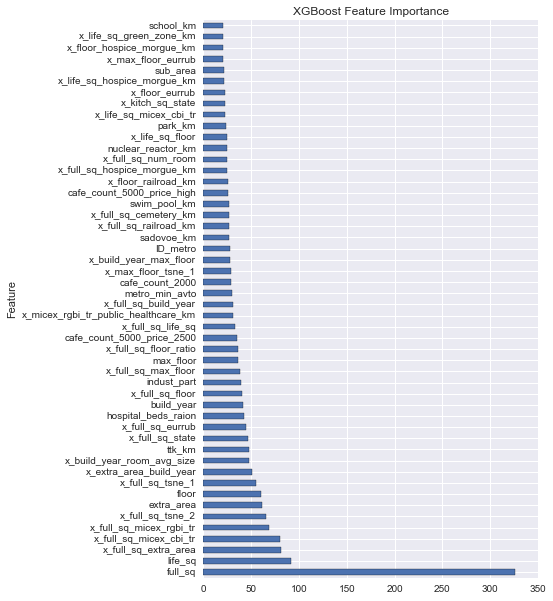

In [130]:
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df  

def plot_importance(model):
    FImportance = get_feature_importance(model).iloc[0:50,]
    plt.figure()
    FImportance.plot(kind='barh', x='Feature', y='Score', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.show()
    
plot_importance(model)